### Import trained model
Run `nvidia-smi -l 1` to check the memory being used by what.
You will need to restart the kernel if the program is crashing as jupyter stays allive and keeps the data in the memory.

In [1]:
import pickle
import keras
import librosa
import librosa.display
import numpy as np
from sklearn import metrics
import tensorflow as tf
from keras.models import load_model

#sound_model_file = "sound_model.pkl"
label_encoder_file = "labelencoder.pkl"


model = None

model = load_model('sound_category_model.h5')

#with open(sound_model_file, 'rb') as file:
#    model = pickle.load(file)

with open(label_encoder_file, 'rb') as file:
    le = pickle.load(file)

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
#%store -r model 
#%store -r le
%store -r X
%store -r y

Using TensorFlow backend.


In [2]:
usl = "../resources/UrbanSound8K/"

In [3]:

num_rows = 40
num_columns = 174
num_channels = 1

max_pad_len = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

7936/7936 [==============================] - 1s 155us/step
Training Accuracy:  0.9889112710952759
1984/1984 [==============================] - 0s 59us/step
Testing Accuracy:  0.9128023982048035


In [4]:
def prediction(file_name, print_data = False):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    if print_data:
        print("The predicted class is:", predicted_class[0], '\n') 
        
        for i in range(len(predicted_proba)): 
            category = le.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )
    return (predicted_class[0], format(predicted_proba[predicted_vector[0]] * 100, '.32f'))

In [5]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return mfccs

In [6]:
# Class: Air Conditioner

filename = usl + 'audio/fold5/100852-0-0-0.wav' 
prediction(filename, True) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99993658065795898437500000000000
car_horn 		 :  0.00000000000016776045884490248250
children_playing 		 :  0.00000320259573527437169104814529
dog_bark 		 :  0.00000000000997690558640629276965
door_bell 		 :  0.00000000000000000487852348283871
drilling 		 :  0.00000281766347143275197595357895
engine_idling 		 :  0.00000070221324222075054422020912
fire_alarm 		 :  0.00000000000000000006882333335723
jackhammer 		 :  0.00005659914313582703471183776855
music 		 :  0.00000000000004278350202867493846
person_talking 		 :  0.00000000000000000000000000389878
shuffling 		 :  0.00000000000000000000004399975829
siren 		 :  0.00000000000000057617907459536484
street_music 		 :  0.00000000054708315655460637572105


('air_conditioner', '99.99365806579589843750000000000000')

In [7]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

### Checking data from testing for more info

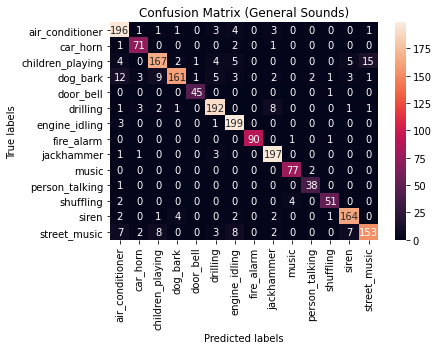

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = le.classes_

plt.figure()
ax= plt.subplot(111)
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (General Sounds)')
ax.xaxis.set_ticklabels(label_names, rotation='vertical');
ax.yaxis.set_ticklabels(label_names, rotation='horizontal');

plt.savefig('confusion_matrix.png', bbox_inches='tight')

plt.show()

### Test with sounds from odas

In [9]:
from os import listdir
from os.path import isfile, join

odas_clips = "/home/sekwah/Music/"

sound_files = [f for f in listdir(odas_clips) if isfile(join(odas_clips, f))]

#print(sound_files)

for file in sound_files:
    try:
        predict = prediction(join(odas_clips, file), False)
        print("{} {}% {}".format(predict[0], predict[1], file))
    except:
        print("Error reading file: " + join(odas_clips, file))